In [ ]:
https://stackoverflow.com/questions/21133878/how-to-convert-data-from-an-excel-spreadsheet-to-a-suitable-representation-for-t

In [92]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install spacy_sentence_bert

You should consider upgrading via the '/Users/lblachnicki/ml/my_env/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 79 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 961 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 129.9 MB 70.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 28.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 8.6 MB/s  eta 0:00:01
     |████████████████████████████████| 3.6 MB 26.4 MB/s eta 0:00:01
     |████████████████████████████████| 880 kB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 26.4 MB/s eta 0:00:01


     |████████████████████████████████| 289 kB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 1.3 MB/s eta 0:00:01
  Created wheel for spacy-sentence-bert: filename=spacy_sentence_bert-0.1.2-py3-none-any.whl size=27202 sha256=84173fb418a9f704b5ed5a0ef4ec6eed49f0c26c34aaa64fbfb6a0f3780e1f3d
  Stored in directory: /Users/lblachnicki/Library/Caches/pip/wheels/54/e2/4a/e3f24fb6729ada3c83377de5217261c0e2f153c5a6f36d37d0
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120748 sha256=c03a5921223848f51f77d2df300ef77158b9c76e6577a46293f409fa83317392
  Stored in directory: /Users/lblachnicki/Library/Caches/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=286534af6d256029b96bb67578581a3aca6b62ef341151e5123e50aab5d96af9
  Stored in directory: /Users/lblachnicki/Library/Caches/pip/wheels/87/39/dd/a83eeef36d0bf9

In [69]:

!{sys.executable} -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/Users/lblachnicki/ml/my_env/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


• Familiarise yourself with the concept of supervised learning (regression, classification)
• Familiarise yourself with the concept of unsupervised learning (clustering)
• Design and implement a data preprocessing pipeline
• Select the regression method and perform experiments on the data
• Select the classification method and perform experiments on the data
• Select the clustering method and perform experiments on the data
• Modify the default parameter values in the methods and repeat the experiments

## Design and implement a data preprocessing pipeline

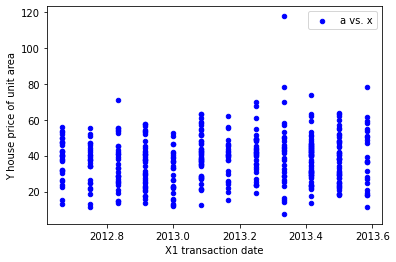

(414, 7) (414,)
(277, 7) (137, 7) (277,) (137,)
(272, 7) (272,)
MAE: 6.177


In [48]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

# read the data set
notebook_path = os.path.abspath("Solution.ipynb")
source_path = os.path.join(os.path.dirname(notebook_path), "datasets/regression/Real estate valuation data set.xlsx")
df = pd.read_excel(source_path,engine='openpyxl')

%matplotlib inline
import matplotlib.pyplot as plt

df.plot(kind="scatter", x="X1 transaction date",y="Y house price of unit area", color="b", label="a vs. x")
plt.show()

data = df.values

# split into inputs and outputs
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)

# split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

In [26]:
# https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/

# contains decent steps
# https://github.com/collindching/Learning-Exercises/tree/master/Box%20Office%20Revenue%20Prediction

# todo use scatterplots to find and remove outliers
# todo standardize?

# nothing null, no need for IMPUTERS
print(np.where(pd.isnull(data)))

from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# separate X and Y values
train_x = data.drop(columns=['Y house price of unit area'])
train_y = data['Y house price of unit area']

pre_process = ColumnTransformer(
    remainder='passthrough',
    transformers=[('drop_columns', 'drop', ['No'])],
)

# Define the Pipeline
"""
Step1: get the oultet binary columns
Step2: pre processing
Step3: Train a Random Forest Model
"""
model_pipeline = Pipeline(steps=[('pre_processing',pre_process),
                                 ('random_forest', RandomForestRegressor(max_depth=10,random_state=2))
                                 ])
# fit the pipeline with the training data
model_pipeline.fit(train_x,train_y)

# predict target values on the training data
print(model_pipeline.predict(train_x))

# print(train_x)
# print(train_y)

(array([], dtype=int64), array([], dtype=int64))
[41.92607195 42.98181718 48.6785788  50.07301921 45.72775183 30.15897974
 38.69983736 47.24618489 19.42375    22.94735298 38.46678835 59.16936281
 40.24359173 24.31120742 34.1875     47.84545544 69.40325    37.70420806
 41.78470902 48.55206589 29.404575   52.47974755 25.72595451 51.10474846
 36.59995952 26.10069682 54.97237827 37.59359143 43.24960666 52.9031313
 21.70375    31.26179566 35.6622804  48.54006751 51.43590161 31.01
 23.440548   26.87059263 45.93780556 49.61561425 15.80899921 18.81585714
 34.78839471 37.45966333 52.07839594 37.91105348 41.37338589 52.22598595
 14.26400278 14.22286111 41.70615308 21.71224277 25.67913425 39.29204004
 51.1226926  13.87716667 39.91806214 54.6622289  21.80975    35.98324333
 23.53559688 60.31442927 26.35690312 52.37159594 25.26405841 50.78478795
 50.72903251 55.22274619 37.47332104 42.11415626 59.28508344 40.25555633
 40.84075326 17.36693849 53.00526148 28.79232814 40.92414913 25.24596929
 31.91662

# Classification

                                            Sentence  Label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1
(1000, 2)
Sentence    0
Label       0
dtype: int64
Sentence    object
Label        int64
dtype: object


<AxesSubplot:>

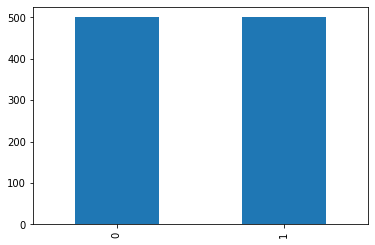

In [90]:
import os
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn import preprocessing

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_fscore_support as score

import spacy
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# https://github.com/nkanu17/reddit-text-classification/blob/master/Text_classification_reddit.ipynb
    # read the data set
notebook_path = os.path.abspath("Solution.ipynb")
source_path = os.path.join(os.path.dirname(notebook_path), "datasets/classification/amazon_cells_labelled.txt")
df = pd.read_csv(source_path, sep='\t', header=None, names=['Sentence', 'Label'])
print(df.head())
print(df.shape)

print(df.isnull().sum())

# lens = df["Sentence"].str.len()
# lens.hist(bins = np.arange(0,200,5))

## OUTPUT
## topic    0
## title    1
## dtype: int64

# data = data.dropna()

#https://docs.seldon.io/projects/seldon-core/en/latest/examples/sklearn_spacy_text_classifier_example.html
print(df.dtypes)

df["Label"].value_counts().plot.bar()


In [95]:
import spacy_sentence_bert

# load one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/
nlp = spacy_sentence_bert.load_model('en_stsb_distilbert_base')

In [96]:
df['vector'] = df['Sentence'].apply(lambda x: nlp(x).vector)


In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['vector'].tolist(), df['Label'].tolist(), test_size=0.33, random_state=42)

In [99]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=9, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9151515151515152
0.9121212121212121


In [104]:
headlines = ["Interesting take on Amazon",
            "Bad design",
            "test"]
labels = [1, 0, 0]

for headline, label in zip(headlines, labels):
  print(headline)
  print(f"True Label: {label}, Predicted Label: {clf.predict(nlp(headline).vector.reshape(1, -1))[0]} \n")

Interesting take on Amazon
True Label: 1, Predicted Label: 1 

Bad design
True Label: 0, Predicted Label: 0 

test
True Label: 0, Predicted Label: 0 

